In [ ]:
%%capture
!pip install langchain_openai
!pip install gradio
!pip install langgraph openai
!pip install langchain-groq

In [ ]:
from typing import Dict, TypedDict
from langgraph.graph import StateGraph, END
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

from IPython.display import display, Image,Markdown
from langchain_core.runnables.graph import MermaidDrawMethod
import os
os.environ["GROQ_API_KEY"] = "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"

In [ ]:
# llm = ChatOpenAI(model="gpt-4", temperature=0)
llm = ChatGroq(
    model="mixtral-8x7b-32768",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [ ]:
class Startupstate(TypedDict):
    startup_idea: str
    market_research: str
    business_model:str
    financial_forecast: str
    pitch: str
    pitch_deck: str
    report: str
    legal_compliance: str

In [ ]:
# Define market agent
def market_research_agent(state: Startupstate):
    """Analyzes the market for the startup idea."""
    prompt = ChatPromptTemplate.from_template("""You are an expert Market Research Agent for startups. Your task is to analyze market trends,
    identify opportunities, and provide detailed SWOT analysis.
    Startup Idea: {startup_idea}
    Always provide data-backed insights with specific numbers, trends, and actionable recommendations.
    Focus on identifying market gaps and suggesting how the startup can fill them.""")

    chain = prompt | llm
    response = chain.invoke({"startup_idea":  state["startup_idea"]}).content
    return {"market_research": response}

In [ ]:
def business_model_agent(state: Startupstate):
    """Recommends optimal business models."""
    prompt = ChatPromptTemplate.from_template("""
You are an expert Business Model Generator for startups. Your job is to recommend the optimal
business model based on market research and startup goals.

Market Research: {market_research}

Always provide structured recommendations with justification for why a particular model would work.
Reference successful companies using similar models when relevant.""")

    chain = prompt | llm
    response = chain.invoke({"market_research":  state["market_research"]}).content
    return {"business_model": response}

In [ ]:
def financial_forecast_agent(state: Startupstate):
    """Generates financial projections and funding requirements."""
    prompt = ChatPromptTemplate.from_template("""
    You are an expert Financial Forecasting Agent for startups. Your job is to create realistic
    financial projections based on the business model and market research.

    Business Model: {business_model}

    Always provide detailed breakdowns with assumptions clearly stated. Be realistic but optimistic
    about the future.
    """)


    chain = prompt | llm
    response = chain.invoke({"business_model":  state["business_model"]}).content
    return {"financial_forecast": response}


In [ ]:
def pitch_deck_agent(state: Startupstate):
    """Generates a compelling pitch deck outline."""
    prompt = ChatPromptTemplate.from_template("""You are an expert Pitch Deck Generator for startups. Your job is to create compelling
    pitch deck outlines that will appeal to investors.

    Financials: {financials}

    Always focus on the story and value proposition. Make it concise, impactful, and visually
    descriptive.
    """)

    chain = prompt | llm
    response = chain.invoke({"financials":  state["financial_forecast"]}).content
    return {"pitch_deck": response}

In [ ]:
def legal_compliance_agent(state: Startupstate):
    """Reviews legal considerations for the startup."""
    prompt = ChatPromptTemplate.from_template("""You are a legal consultant. Based on the startup details, suggest business structures, IP protection strategies, and regulatory considerations.

    Pitch Deck: {pitch_deck}

    Provide structured insights with key observations and, if applicable, potential recommendations.""")

    chain = prompt | llm
    response = chain.invoke({"pitch_deck":  state["pitch_deck"]}).content
    return {"legal_compliance": response}


In [ ]:
def summary_generation_agent(state: Startupstate):
    """Compiles all findings into a structured startup analysis summary."""
    prompt = ChatPromptTemplate.from_template("""You are a startup consultant. Compile all findings into a structured report including market research, business model, financials, pitch deck, and legal recommendations.

    Market Research: {market_research}
    Business Model: {business_model}
    Financial Forecast: {financial_forecast}
    Pitch Deck: {pitch_deck}
    Legal Compliance: {legal_compliance}
    Provide a well-organized summary for the user.""")

    chain = prompt | llm
    response = chain.invoke({"market_research": state["market_research"],
                             "business_model": state["business_model"],
                             "financial_forecast": state["financial_forecast"],
                             "pitch_deck": state["pitch_deck"],
                             "legal_compliance": state["legal_compliance"]}).content
    return {"report": response}

In [ ]:
# Create workflow graph
graph = StateGraph( Startupstate)
graph.add_node("market_research_agent", market_research_agent)
graph.add_node("business_model_agent", business_model_agent)
graph.add_node("financial_forecast_agent", financial_forecast_agent)
graph.add_node("pitch_deck_agent", pitch_deck_agent)
graph.add_node("legal_compliance_agent", legal_compliance_agent)
graph.add_node("summary_generation_agent", summary_generation_agent)
graph.set_entry_point("market_research_agent")

graph.add_edge("market_research_agent", "business_model_agent")
graph.add_edge("business_model_agent", "financial_forecast_agent")
graph.add_edge("financial_forecast_agent", "pitch_deck_agent")
graph.add_edge("pitch_deck_agent", "legal_compliance_agent")
graph.add_edge("legal_compliance_agent", "summary_generation_agent")
graph.add_edge("summary_generation_agent",  END)

# Compile the graph
graph = graph.compile()

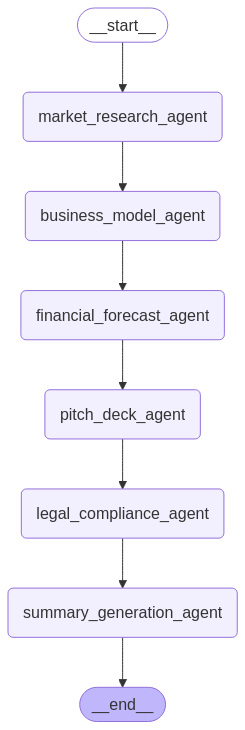

In [ ]:
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [ ]:
startup_idea = "A SaaS platform to help restaurants reduce food waste"

In [ ]:
result = graph.invoke({"startup_idea": startup_idea})

In [ ]:
result

{'startup_idea': 'A SaaS platform to help restaurants reduce food waste',
 'market_research': "Sure, I'd be happy to help! Here's a data-backed analysis of the market trends, opportunities, and a SWOT analysis for a SaaS platform that helps restaurants reduce food waste:\n\nMarket Trends:\n\n* According to a report by ReFED, a nonprofit organization focused on reducing food waste, the U.S. restaurant industry generates 11.4 million tons of food waste annually, costing an estimated $25 billion.\n* Consumers are becoming increasingly environmentally conscious, and are more likely to support businesses that prioritize sustainability. A survey by Nielsen found that 73% of global consumers are willing to change their purchasing habits to reduce their environmental impact.\n* The COVID-19 pandemic has had a significant impact on the restaurant industry, with many establishments closing temporarily or permanently. This has led to an increase in food waste, as restaurants are unable to sell or

In [ ]:
Markdown(result["report"])

Sure, here's a summary of the findings and recommendations for your SaaS platform that helps restaurants reduce food waste:

Market Research:

* The U.S. restaurant industry generates 11.4 million tons of food waste annually, costing an estimated $25 billion.
* Consumers are becoming increasingly environmentally conscious and are more likely to support businesses that prioritize sustainability.
* The COVID-19 pandemic has had a significant impact on the restaurant industry, leading to an increase in food waste.
* There is a clear market gap for a SaaS platform that helps restaurants reduce food waste.

Business Model:

* The Freemium Business Model is recommended for this startup, as it allows for a large user base and scalability.
* The startup can offer a free version of the platform with basic features, and upsell users to the premium version with advanced features.

Financial Forecast:

* The financial projections for the first three years are optimistic but realistic, with the startup becoming profitable in the third year.
* The initial investment of $100,000 will be used to cover the operating costs in the first year.

Pitch Deck:

* The pitch deck should focus on the story and value proposition of the platform, while also including the financial projections.
* The pitch deck should be concise, impactful, and visually descriptive.

Legal Compliance:

* The startup should consider forming an LLC or a C Corporation, depending on its needs and goals.
* The startup should consider filing for patents, trademarks, and copyrights to protect its intellectual property.
* The startup should ensure compliance with relevant regulations, such as data privacy, food safety, and advertising.

Overall, the market research, business model, financial forecast, pitch deck, and legal compliance recommendations provide a structured report for your SaaS platform that helps restaurants reduce food waste. By following these recommendations, the startup can increase its chances of success and impact in the market.

In [ ]:
Markdown(result["legal_compliance"])

Based on the startup details provided, here are some structured insights on business structures, IP protection strategies, and regulatory considerations:

Business Structures:

* Limited Liability Company (LLC): An LLC is a popular choice for startups because it provides personal liability protection for the founders while also being relatively easy to set up and maintain. An LLC can also provide tax benefits, as it allows for pass-through taxation, meaning the company's profits and losses are reported on the founders' personal tax returns.
* C Corporation: A C Corporation is a separate legal entity from its founders, providing strong personal liability protection. This structure is often chosen by startups that plan to seek venture capital funding, as it allows for an unlimited number of shareholders and the ability to issue multiple classes of stock. However, C Corporations are subject to double taxation, meaning the company's profits are taxed at the corporate level and then again at the individual level when distributed as dividends.

IP Protection Strategies:

* Patents: If your SaaS platform includes any unique technology or processes, consider filing for a patent to protect your intellectual property. Patents can provide up to 20 years of exclusive rights to your invention, preventing others from using, selling, or manufacturing it without your permission.
* Trademarks: Trademarks can be used to protect your company's name, logo, and slogan. Registering a trademark can provide legal protection against others using similar marks, helping to establish brand recognition and reputation.
* Copyrights: Copyrights can be used to protect original works of authorship, such as software code, website content, and marketing materials. Registering a copyright can provide legal evidence of ownership and the right to sue for infringement.

Regulatory Considerations:

* Data Privacy: If your SaaS platform collects or stores personal data from users, you may be subject to data privacy regulations such as the General Data Protection Regulation (GDPR) or the California Consumer Privacy Act (CCPA). Compliance with these regulations may require implementing specific data protection measures and providing users with certain rights regarding their data.
* Food Safety: If your platform provides recommendations or guidance on food preparation or handling, you may be subject to food safety regulations. Compliance with these regulations may require obtaining necessary certifications and following specific food safety protocols.
* Advertising: If your platform includes any advertising or promotional materials, you may be subject to advertising regulations. Compliance with these regulations may require avoiding false or misleading claims and providing clear and conspicuous disclosures.

Overall, it's important to consult with a legal professional to ensure that your startup is properly structured, protected, and compliant with relevant regulations.

In [ ]:
Markdown(result["business_model"])

Based on the market research provided, I would recommend the Freemium Business Model for this SaaS platform that helps restaurants reduce food waste.

Justification:

1. Large Market Opportunity: With the U.S. restaurant industry generating 11.4 million tons of food waste annually, there is a significant market opportunity for this startup. By offering a free version of the platform, the startup can attract a large user base and then upsell them to the premium version.
2. Overcoming Competition: The Freemium Business Model can help the startup differentiate itself from competitors by providing a free version of the platform. This can help the startup gain market share and build brand awareness, even if it faces competition from established waste management companies and other startups.
3. Consumer Preference for Sustainability: The growing trend of consumers prioritizing sustainability presents an opportunity for the startup to attract customers. By offering a free version of the platform, the startup can appeal to environmentally conscious consumers who may be hesitant to pay for a new technology.
4. Scalability: The Freemium Business Model is highly scalable, as the startup can acquire a large user base without incurring significant costs. This can help the startup expand its reach and impact, particularly as it targets different restaurant sizes and types.
5. Successful Precedents: The Freemium Business Model has been successful for other SaaS companies, such as Dropbox and Slack. By offering a free version of the platform, these companies were able to acquire a large user base and then upsell them to the premium version.

Actionable Recommendations:

1. Offer a Free Version: The startup should offer a free version of the platform that includes basic features, such as food waste tracking and management. This can help the startup attract a large user base and build brand awareness.
2. Upsell to Premium Version: The startup should upsell users to the premium version of the platform, which includes advanced features, such as data-driven insights and customized recommendations. This can help the startup generate revenue and increase its impact.
3. Provide Clear Value Proposition: The startup should clearly communicate the value proposition of the premium version of the platform, such as cost savings and sustainability benefits. This can help the startup convince restaurants to upgrade to the premium version.
4. Offer Incentives for Upgrading: The startup should offer incentives for upgrading to the premium version, such as discounts or additional features. This can help the startup encourage users to upgrade and increase its revenue.
5. Monitor User Behavior: The startup should monitor user behavior and feedback to continuously improve the platform and the user experience. This can help the startup optimize its Freemium Business Model and increase its impact.

In [ ]:
%%capture
!pip install reportlab

In [ ]:
import gradio as gr
import tempfile
import os
from reportlab.lib.pagesizes import letter
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.enums import TA_CENTER, TA_JUSTIFY
from reportlab.pdfbase import pdfmetrics
from reportlab.pdfbase.ttfonts import TTFont
from reportlab.lib import colors

def agent_interface(user_input):
    """Process user input through the LangGraph agent workflow."""
    try:
        inputs = {"startup_idea": user_input}
        result = graph.invoke(inputs)
        # Extract key responses
        output_keys = [
            "market_research", "business_model", "financial_forecast",
            "pitch_deck", "legal_compliance", "report"
        ]
        outputs = {key: result.get(key, "No data available.") for key in output_keys}
        # Generate report file
        file_path = generate_pdf_report(user_input, outputs)
        return (*outputs.values(), file_path)  # Return all outputs + file path
    except Exception as e:
        error_msg = f"Error: {str(e)}"
        return [error_msg] * 6 + [None]  # Last output is file, so return None

def generate_pdf_report(user_input, outputs):
    """Creates a downloadable PDF report file."""
    # Save as a temporary PDF file
    temp_dir = tempfile.gettempdir()
    file_path = os.path.join(temp_dir, "startup_report.pdf")

    # Create PDF document
    doc = SimpleDocTemplate(file_path, pagesize=letter)
    styles = getSampleStyleSheet()

    # Create custom styles
    title_style = ParagraphStyle(
        'TitleStyle',
        parent=styles['Heading1'],
        alignment=TA_CENTER,
        textColor=colors.darkblue,
        fontSize=16,
        spaceAfter=12
    )

    subtitle_style = ParagraphStyle(
        'SubTitleStyle',
        parent=styles['Heading2'],
        textColor=colors.darkblue,
        fontSize=14,
        spaceAfter=10
    )

    # Create justified text style for content
    justified_style = ParagraphStyle(
        'JustifiedStyle',
        parent=styles['Normal'],
        alignment=TA_JUSTIFY,
        spaceAfter=6
    )

    footer_style = ParagraphStyle(
        'FooterStyle',
        parent=styles['Normal'],
        alignment=TA_CENTER,
        textColor=colors.darkgrey,
        fontSize=8
    )

    # Build content
    content = []

    # Add title
    content.append(Paragraph("Nafabat.AI Startup Agent Using LangGraph", title_style))
    content.append(Spacer(1, 12))

    # Add report content sections
    content.append(Paragraph("Startup Idea Report", subtitle_style))
    content.append(Spacer(1, 6))

    content.append(Paragraph("<b>User Input:</b>", styles["Heading3"]))
    content.append(Paragraph(user_input, justified_style))
    content.append(Spacer(1, 10))

    content.append(Paragraph("<b>Market Research:</b>", styles["Heading3"]))
    content.append(Paragraph(outputs['market_research'], justified_style))
    content.append(Spacer(1, 10))

    content.append(Paragraph("<b>Business Model:</b>", styles["Heading3"]))
    content.append(Paragraph(outputs['business_model'], justified_style))
    content.append(Spacer(1, 10))

    content.append(Paragraph("<b>Financial Forecast:</b>", styles["Heading3"]))
    content.append(Paragraph(outputs['financial_forecast'], justified_style))
    content.append(Spacer(1, 10))

    content.append(Paragraph("<b>Pitch Deck:</b>", styles["Heading3"]))
    content.append(Paragraph(outputs['pitch_deck'], justified_style))
    content.append(Spacer(1, 10))

    content.append(Paragraph("<b>Legal Compliance:</b>", styles["Heading3"]))
    content.append(Paragraph(outputs['legal_compliance'], justified_style))
    content.append(Spacer(1, 10))

    content.append(Paragraph("<b>Final Report:</b>", styles["Heading3"]))
    content.append(Paragraph(outputs['report'], justified_style))
    content.append(Spacer(1, 20))

    # Add footer
    content.append(Paragraph("Created by Abdullahi Ahmad", footer_style))

    # Build the PDF
    doc.build(content)

    return file_path

# Create Gradio Interface
demo = gr.Interface(
    fn=agent_interface,
    inputs=gr.Textbox(
        lines=5,
        placeholder="Describe your startup idea, including its industry and key features..."
    ),
    outputs=[
        gr.Textbox(lines=6, label="Market Research"),
        gr.Textbox(lines=6, label="Business Model"),
        gr.Textbox(lines=6, label="Financial Forecast"),
        gr.Textbox(lines=6, label="Pitch Deck"),
        gr.Textbox(lines=6, label="Legal Compliance"),
        gr.Textbox(lines=6, label="Report"),
        gr.File(label="Download Report")  # Adds a file output
    ],
    title="Startup Adviser",
    description="### Get AI-driven insights to refine your startup idea. 🚀\nEnter a brief description of your business concept and receive structured feedback.",
)

if __name__ == "__main__":
    demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5061924daec63fcb2a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
